# Eda - Grupo 2

## Importando as bibliotecas necessárias

In [102]:
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
sns.color_palette("crest", as_cmap=True)
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

from tqdm import tqdm
tqdm.pandas(desc="my bar!")

## Tables

Carregando o banco de dados, já tratado anteriormente

In [103]:
df = pd.read_pickle('../datasets/processed/movies.pkl')
df.head()

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,budget,income,country_of_origin
0,Avatar: The Way of Water,8.0,2022,December,PG-13,192,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Action, Adventure, Fantasy",New Zealand,350000000.0,681081686.0,United States
1,Guillermo del Toro's Pinocchio,7.8,2022,December,PG,117,"Guillermo del Toro, Mark Gustafson","Ewan McGregor, David Bradley, Gregory Mann, Bu...","Animation, Drama, Family",USA,35000000.0,71614.0,"United States, Mexico, France"
2,Bullet Train,7.3,2022,August,R,127,David Leitch,"Brad Pitt, Joey King, Aaron Taylor Johnson, Br...","Action, Comedy, Thriller",Japan,85900000.0,239268602.0,"Japan, United States"
3,The Banshees of Inisherin,8.0,2022,November,R,114,Martin McDonagh,"Colin Farrell, Brendan Gleeson, Kerry Condon, ...","Comedy, Drama",Ireland,40000000.0,19720823.0,"Ireland, United Kingdom, United States"
4,M3gan,6.7,2022,January,PG-13,102,Gerard Johnstone,"Jenna Davis, Amie Donald, Allison Williams, Vi...","Horror, Sci-Fi, Thriller",New Zealand,40000000.0,90776006.5,United States


In [104]:
df.describe()

,rating,year,runtime,budget,income
count,2000.000000,2000.000000,2000.000000,2.000000e+03,2.000000e+03
mean,6.667650,2012.500000,113.214500,5.794723e+07,1.807404e+08
std,0.912576,5.767723,19.598075,5.644956e+07,2.645420e+08
min,1.900000,2003.000000,50.000000,1.000000e+01,3.050000e+02
25%,6.175000,2007.750000,99.000000,2.000000e+07,2.931354e+07
50%,6.700000,2012.500000,110.000000,4.000000e+07,9.077601e+07
75%,7.300000,2017.250000,124.000000,7.500000e+07,2.081357e+08
max,9.600000,2022.000000,242.000000,3.560000e+08,2.922918e+09


In [105]:
df.describe(exclude=['float64', 'uint16', 'uint32', 'uint8'])

,title,month,certificate,directors,stars,genre,filming_location,country_of_origin
count,2000,2000,2000,2000,2000,2000,2000,2000
unique,1989,12,11,1082,1990,244,97,406
top,The Hunt,November,R,Ridley Scott,"Jennifer Lawrence, Josh Hutcherson, Liam Hemsw...","Action, Adventure, Sci-Fi",USA,United States
freq,2,262,901,13,2,92,906,942


In [106]:
def classification_of_runtime(x: int) -> str:
    if x < 60:
        return 'short'
    elif x < 120:
        return 'medium'
    elif x < 180:
        return 'long'
    else:
        return 'eternity'

df['time_classification'] = df.runtime.progress_apply(classification_of_runtime)
del classification_of_runtime

my bar!: 100%|██████████| 2000/2000 [00:00<00:00, 803814.49it/s]


In [107]:
df['profit'] = df.income - df.budget
df['proportional_profit'] = np.round(df.income/df.budget*100, 2)
df['budget_per_million'] = df['budget'] / 1_000_000
df['income_per_million'] = df['income'] / 1_000_000

In [108]:
def classification_of_profit(x: int) -> str:
    if x < 0:
        return 'failure'
    else:
        return 'gain'

df['profit_classification'] = df.profit.progress_apply(classification_of_profit)

my bar!: 100%|██████████| 2000/2000 [00:00<00:00, 489302.85it/s]


In [109]:
df.profit_classification.value_counts()

gain       1551
failure     449
Name: profit_classification, dtype: int64

### Observando um pouco os valores pertencentes as colunas de strings

In [110]:
def list_of_str(array: np.ndarray) -> pd.DataFrame:
    new_df = pd.Series(np.sum((array) + ',').split(',')).str.strip()
    test = new_df.copy()
    new_df = pd.DataFrame(list(set(new_df)), columns=[array.name])
    new_df.drop(index=new_df[new_df[array.name] == ''].index, inplace=True)
    new_df.reset_index(drop=True, inplace=True)
    new_df['frequency'] = [test.str.fullmatch(item).sum() for item in tqdm(new_df[array.name].values)]
    new_df['rating'] = [df[df[array.name].str.contains(item)]['rating'].mean() for item in tqdm(new_df[array.name].values)]
    new_df['year'] = [df[df[array.name].str.contains(item)]['year'].values for item in tqdm(new_df[array.name].values)]
    new_df['runtime'] = [df[df[array.name].str.contains(item)]['runtime'].mean() for item in tqdm(new_df[array.name].values)]
    new_df['profit'] = [df[df[array.name].str.contains(item)]['profit'].mean() for item in tqdm(new_df[array.name].values)]
    new_df['profit_classification'] = [df[df[array.name].str.contains(item)]['profit_classification'].mode()[0] for item in tqdm(new_df[array.name].values)]
    
    return new_df

In [111]:
list_of_directors = list_of_str(df.directors)

100%|██████████| 1151/1151 [00:01<00:00, 1050.53it/s]


In [112]:
list_of_directors.sort_values('frequency', ascending=False).head(10)

,directors,frequency,rating,year,runtime,profit,profit_classification
71,Ridley Scott,13,6.892308,"[2021, 2021, 2017, 2015, 2014, 2013, 2012, 201...",136.076923,1.199349e+08,gain
729,Steven Spielberg,12,7.216667,"[2022, 2021, 2018, 2017, 2015, 2012, 2011, 201...",136.500000,2.062659e+08,gain
298,Antoine Fuqua,11,6.554545,"[2022, 2021, 2021, 2018, 2016, 2015, 2014, 201...",120.636364,6.385396e+07,gain
182,Michael Bay,10,6.310000,"[2019, 2017, 2016, 2014, 2013, 2011, 2009, 200...",145.000000,3.609068e+08,gain
60,Clint Eastwood,10,7.630000,"[2019, 2018, 2016, 2014, 2009, 2008, 2008, 200...",127.800000,1.519732e+08,gain
293,Shawn Levy,10,6.340000,"[2021, 2014, 2014, 2013, 2011, 2010, 2009, 200...",105.400000,1.753495e+08,gain
401,Tim Burton,9,6.944444,"[2016, 2014, 2012, 2012, 2010, 2007, 2005, 200...",108.222222,1.924092e+08,gain
1138,Joel Coen,9,7.133333,"[2021, 2018, 2016, 2013, 2010, 2009, 2008, 200...",109.111111,7.200790e+07,gain
116,Quentin Tarantino,9,7.866667,"[2019, 2015, 2012, 2009, 2007, 2007, 2005, 200...",148.555556,1.467708e+08,gain
736,Zack Snyder,9,6.866667,"[2021, 2021, 2017, 2016, 2013, 2011, 2009, 200...",143.777778,1.962998e+08,gain


In [113]:
list_of_stars = list_of_str(df.stars)

100%|██████████| 3502/3502 [00:03<00:00, 938.72it/s] 


In [114]:
list_of_stars.sort_values('frequency', ascending=False).head(10)

,stars,frequency,rating,year,runtime,profit,profit_classification
2607,Dwayne Johnson,25,6.460000,"[2022, 2021, 2021, 2019, 2019, 2019, 2018, 201...",116.080000,3.204124e+08,gain
1156,Mark Wahlberg,24,6.504167,"[2022, 2021, 2020, 2018, 2018, 2017, 2017, 201...",115.875000,1.600243e+08,gain
1040,Ryan Reynolds,23,6.608696,"[2022, 2021, 2021, 2020, 2019, 2018, 2017, 201...",108.260870,1.327418e+08,gain
1806,Brad Pitt,22,7.263636,"[2022, 2022, 2019, 2019, 2016, 2015, 2014, 201...",134.045455,1.519059e+08,gain
3393,Scarlett Johansson,22,7.195455,"[2021, 2021, 2019, 2019, 2017, 2016, 2016, 201...",117.318182,2.219786e+08,gain
3283,Amy Adams,22,6.981818,"[2022, 2021, 2020, 2018, 2016, 2016, 2016, 201...",122.181818,1.074979e+08,gain
1364,Matt Damon,22,7.013636,"[2021, 2021, 2019, 2017, 2017, 2016, 2016, 201...",124.272727,1.279186e+08,gain
1106,Cate Blanchett,21,7.128571,"[2022, 2022, 2021, 2021, 2018, 2017, 2015, 201...",128.619048,1.859009e+08,gain
1619,Samuel L Jackson,21,6.871429,"[2019, 2019, 2019, 2017, 2017, 2016, 2015, 201...",119.571429,2.759451e+08,gain
558,Tom Hanks,21,6.957143,"[2022, 2022, 2022, 2021, 2020, 2020, 2019, 201...",119.571429,1.979458e+08,gain


### Agrupando algumas colunas

In [115]:
df.groupby('time_classification').agg({
    'rating': ['mean', 'median']
})

rating       
                         mean median
time_classification                 
eternity             7.850000   7.85
long                 7.091587   7.10
medium               6.459027   6.50
short                8.500000   8.50

In [116]:
df.groupby('year').agg({
    'rating': ['mean', 'median'], 
    'runtime': ['mean', 'median'],
    'profit': ['mean', 'median']
})

rating        runtime               profit             
       mean median    mean median          mean       median
year                                                        
2003  6.579   6.70  110.79  108.0  9.659462e+07  54687685.50
2004  6.746   6.80  111.03  106.0  1.056355e+08  69223069.50
2005  6.565   6.70  111.15  109.0  9.027620e+07  45003317.00
2006  6.713   6.75  112.87  108.0  9.156999e+07  41425535.00
2007  6.756   6.95  112.12  109.5  1.064206e+08  51594050.50
2008  6.596   6.70  107.73  106.0  1.205450e+08  73601433.50
2009  6.679   6.75  111.85  107.0  1.298643e+08  53456890.00
2010  6.691   6.60  108.69  107.0  1.261730e+08  63240140.00
2011  6.754   6.80  110.60  107.5  1.401639e+08  61960593.00
2012  6.675   6.75  112.58  109.0  1.631328e+08  81792810.00
2013  6.734   6.75  113.67  112.0  1.513409e+08  66122980.00
2014  6.692   6.60  113.05  109.0  1.622891e+08  87037858.50
2015  6.688   6.75  116.02  117.0  1.690774e+08  49983764.75
2016  6.762   6.85  114.25  114.5  1.578052e+08  82562837.80
2017  6.714   6.70  115.10  115.0  1.619302e+08  50776006.50
2018  6.677   6.75  117.24  118.0  1.751331e+08  50776006.50
2019  6.691   6.75  117.37  117.0  1.724727e+08  50776006.50
2020  6.326   6.50  107.80  105.5  2.415700e+07  13192939.00
2021  6.612   6.60  118.09  114.5  5.081962e+07    735171.00
2022  6.703   6.70  122.29  118.5  6.046228e+07  40223898.50

In [117]:
df.groupby('year')[
    [
        'month', 'certificate', 
        'directors', 'filming_location', 
        'profit_classification'
    ]
].agg(lambda x: x.mode()[0])

,month,certificate,directors,filming_location,profit_classification
year,,,,,
2003,November,R,"Lana Wachowski, Lilly Wachowski",USA,gain
2004,July,R,Garry Marshall,USA,gain
2005,December,PG-13,Catherine Hardwicke,USA,gain
2006,November,R,Shawn Levy,USA,gain
2007,November,R,Richard LaGravenese,USA,gain
2008,December,PG-13,Clint Eastwood,USA,gain
2009,December,R,Christian Alvart,USA,gain
2010,June,R,Adam Green,USA,gain
2011,August,R,Steven Spielberg,USA,gain


### Proporções de algumas colunas

In [118]:
pd.DataFrame(zip(
    df.certificate.value_counts(), 
    df.certificate.value_counts(normalize=True)
    ), index=df.certificate.value_counts().index, columns=['count', 'percentage'])

,count,percentage
R,901,0.4505
PG-13,714,0.3570
PG,225,0.1125
Unrated,67,0.0335
TV-MA,40,0.0200
G,22,0.0110
TV-14,12,0.0060
TV-PG,9,0.0045
NC-17,6,0.0030
TV-G,3,0.0015


In [119]:
pd.DataFrame(zip(
    df.filming_location.value_counts(), 
    df.filming_location.value_counts(normalize=True)
    ), index=df.filming_location.value_counts().index, columns=['count', 'percentage'])

,count,percentage
USA,906,0.4530
Canada,209,0.1045
UK,177,0.0885
Unknown,76,0.0380
Australia,44,0.0220
...,...,...
Guam,1,0.0005
Gabon,1,0.0005
French Polynesia,1,0.0005
Rwanda,1,0.0005


In [120]:
pd.DataFrame(zip(
    df.month.value_counts(), 
    df.month.value_counts(normalize=True)
    ), index=df.month.value_counts().index, columns=['count', 'percentage'])

,count,percentage
November,262,0.1310
December,248,0.1240
October,187,0.0935
June,166,0.0830
July,152,0.0760
September,151,0.0755
March,150,0.0750
August,149,0.0745
January,149,0.0745
May,144,0.0720


Observando os valores max e min

In [121]:
df.query('profit == @df.profit.min() | profit == @df.profit.max()')

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,budget,income,country_of_origin,time_classification,profit,proportional_profit,budget_per_million,income_per_million,profit_classification
123,Zack Snyder's Justice League,8.0,2021,March,R,242,Zack Snyder,"Henry Cavill, Ben Affleck, Gal Gadot, Amy Adams","Action, Adventure, Fantasy",Iceland,300000000.0,9.077601e+07,United States,eternity,-2.092240e+08,30.26,300.0,90.776006,failure
1300,Avatar,7.8,2009,December,PG-13,162,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Action, Adventure, Fantasy",USA,237000000.0,2.922918e+09,United States,long,2.685918e+09,1233.30,237.0,2922.917914,gain


Obtendo os dados que tiveram fracassado na bilheteria e uma nota boa

In [122]:
pd.DataFrame(df.query('profit_classification == "failure" & rating >= 7').title.values, columns=['title'])

,title
0,Guillermo del Toro's Pinocchio
1,The Banshees of Inisherin
2,The Whale
3,The Fabelmans
4,Babylon
...,...
135,Memories of Murder
136,Tokyo Godfathers
137,A Mighty Wind
138,A Tale of Two Sisters


In [123]:
pd.DataFrame(zip(
    df.query('profit_classification == "failure"').year.value_counts(sort=False), 
    df.query('profit_classification == "failure" & rating >= 7').year.value_counts(sort=False)
    ), index=df.query('profit_classification == "failure" & rating >= 7').year.unique(), columns=['failure', 'failure_and_positive_rating'])

,failure,failure_and_positive_rating
2022,39,19
2021,49,18
2020,46,9
2019,27,9
2018,22,6
2017,23,10
2016,19,6
2015,17,5
2014,20,6
2012,12,6


In [124]:
bins = [0.1, 5 ,10, 25, 50, 100, 150, 200, 250, float('inf')]
labels = ['0.1-5', '5-10','10-25', '25-50', '50-100', '100-150', '150-200', '200-250', '250+']
df['budget_range'] = pd.cut(df['budget_per_million'], bins=bins, labels=labels)

budget_counts = df['budget_range'].value_counts(normalize=True) * 100

print(budget_counts)

25-50      34.824121
50-100     17.487437
10-25      16.432161
100-150     8.542714
0.1-5       8.341709
150-200     6.231156
5-10        5.979899
200-250     1.507538
250+        0.653266
Name: budget_range, dtype: float64


Função para análise entre duas colunas com tratamento dos dados

In [125]:
def analise_2colunas(df_coluna_1, df_coluna_2, colunas):
    date_1 = df_coluna_1.str.split(", ")
    df_1 = [term for lis in date_1 for term in lis]
    df_2 = [term for idx_2, term in enumerate(df_coluna_2) for x in range(len(date_1[idx_2]))]
    df = pd.DataFrame(list(zip(df_1, df_2)), columns = colunas)
    return df.copy()
    
# Diretores pelas avaliações
director_for_rating = analise_2colunas(df['directors'], df['rating'], ['director', 'rating'])

In [126]:
director_for_rating = director_for_rating.groupby(['director'], as_index = False).agg(mean = ('rating', 'mean'))
directors = director_for_rating.sort_values('mean', ascending=False).head(10)
directors

,director,mean
8,Abhishek Pathak,8.6
1150,ric Toledano,8.5
897,Rishab Shetty,8.5
806,Olivier Nakache,8.5
365,Gemma Mc Carthy,8.5
19,Adrian Molina,8.4
1062,Thomas Kail,8.4
922,Rodney Rothman,8.4
877,Rajkumar Hirani,8.4
766,Nadine Labaki,8.4


### Merge com o df oscar_award

In [127]:
df_oscar = pd.read_pickle("../datasets/processed/the_oscar_award.pkl")
df_oscar.rename(columns={'year_film': 'year', 'film': 'title'}, inplace=True)
df_oscar.head()

#Pega os filmes que ganharam Oscar a partir de 2003
df_oscar_2003_up = df_oscar.loc[(df_oscar['year']>= 2003) & (df_oscar['winner']==True)]

#Pega os filmes que ganharam Oscar de melhor FILME a partir de 2003
df_oscar_2003_up_best_picture = df_oscar_2003_up.loc[(df_oscar_2003_up['category'] == 'BEST PICTURE')]

#Cria um DataSeries de quantidade de Oscars' recebidos
df_group_oscar_2003_up_prize_quantity = df_oscar_2003_up.groupby(['title']).size().reset_index()

#Cria títulos para colunas
df_group_oscar_2003_up_prize_quantity.columns = ["title", "oscars"]

#Junta as df's => df + df_oscar_2003_up
df_merge = df.merge(df_oscar_2003_up, how="inner", on=["title", "year"])

In [128]:
#ganhadores de melhores filmes a partir de 2003
array_oscar_2003_up_best_picture = np.array(df_oscar_2003_up_best_picture['title'].unique())

#ganhadores de melhores filmes a partir de 2003 pelo df do IMDB
df_merge_best_picture = df_merge.loc[df_merge['category']== 'BEST PICTURE']

array_df_merge_best_picture = np.array(df_merge_best_picture["title"].unique())

#print(f"ARRAY 1 {array_oscar_2003_up_best_picture}\nARRAY 2 {array_df_merge_best_picture}")

#Descobrir os filmes faltantes no dataset do IMDB que ganharam o Oscar de melhor filme
array_resultado = np.setdiff1d(array_oscar_2003_up_best_picture, array_df_merge_best_picture)

print(f'RESULTADO {array_resultado}')

RESULTADO ['Crash' 'The Artist' 'The Hurt Locker']


In [129]:

'''
O por quê de ser um outlier - Número de Oscars? | Popularidade? | Qualidade?
'''

'''
No Rotten Tomatoes
-------------------------------------------------------------------------------------

INCEPTION                                     => 87% TOMATOMETER & 91% AUDIENCE SCORE

THE DARK KNIGHT RISES                         => 87% TOMATOMETER & 90% AUDIENCE SCORE

THE LORD OF THE RINGS: THE RETURN OF THE KING => 93% TOMATOMETER & 86% AUDIENCE SCORE
'''

# Descobrimos o outlier

outlier = df.loc[df['rating']> 8.75]
print(outlier['title'].unique())

['67th Street, New York, NY' 'Inception' 'My Little Princess'
 'The Dark Knight' 'The Lord of the Rings: The Return of the King']


## Plots

### Criando algumas funções para facilitar na plotagem

In [130]:
def create_bar(df_: pd, ax_: plt.axes, x_: str, y_: str, agg_: str, title_:str, rot=45):
    df = df_.groupby(by=x_, as_index=False)[y_].agg(agg_)
    try:
        df[x_] = df[x_].str.capitalize()
    except:
        pass
    
    if x_ in 'month':
        order_ = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        sns.barplot(data=df, x=x_, y=y_, ax=ax_, order=order_, palette="crest")
    else:
        sns.barplot(data=df, x=x_, y=y_, ax=ax_, palette="crest")
    
    
    for value in ax_.containers:
        ax_.bar_label(value)
    ax_.tick_params(axis='x', labelrotation=rot, size=12)
    ax_.tick_params(axis='y', size=12)
    ax_.set_xlabel(x_.capitalize(), fontsize='large', family='monospace')
    ax_.set_ylabel(y_.capitalize(), fontsize='large', family='monospace')
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')
    
def create_box(df: pd, ax_: plt.axes, x_: str, y_: str, title_:str, rot=45):
    try:
        df[x_] = df[x_].str.capitalize()
    except:
        pass
    
    if x_ in 'month':
        order_ = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        sns.boxplot(data=df, x=x_, y=y_, ax=ax_, order=order_, palette="crest")
    else:
        sns.boxplot(data=df, x=x_, y=y_, ax=ax_, palette="crest")
    
    ax_.tick_params(axis='x', labelrotation=rot, size=12)
    ax_.tick_params(axis='y', size=12)
    ax_.set_xlabel(x_.capitalize(), fontsize='large', family='monospace')
    ax_.set_ylabel(y_.capitalize(), fontsize='large', family='monospace')
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')
    
def create_scatter(df: pd, ax_: plt.axes, x_: str, y_: str, hue_: str, title_: str):
    sns.scatterplot(data=df, x=x_, y=y_, hue=hue_, size=hue_, alpha = 0.75, ax=ax_)
    ax_.set_xlabel(x_.capitalize(), fontsize='large', family='monospace')
    ax_.set_ylabel(y_.capitalize(), fontsize='large', family='monospace')
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')

In [131]:
genre_for_year = analise_2colunas(df['genre'], df['year'], ['genre', 'year'])
genre_for_year = genre_for_year.groupby(['genre', 'year'], as_index = False).agg(count = ('genre', 'count'))

fig = px.line(genre_for_year, x = 'year',y ='count',
              color = 'genre',
              title='Relação da quantidade de filmes por generos e ano')
fig.update_xaxes(dtick="M1")
fig.show()

In [132]:
genre_for_budget = analise_2colunas(df['genre'], df['budget'], ['genre', 'budget'])
genre_for_budget = genre_for_budget.groupby('genre', as_index = False).agg(mean = ('budget', 'mean'))

fig = px.histogram(genre_for_budget, x = 'genre', y ='mean', 
                   color_discrete_sequence= ['#37AA9C'])
fig.update(layout_title_text='Média do orçamento por gênero')
fig.show()

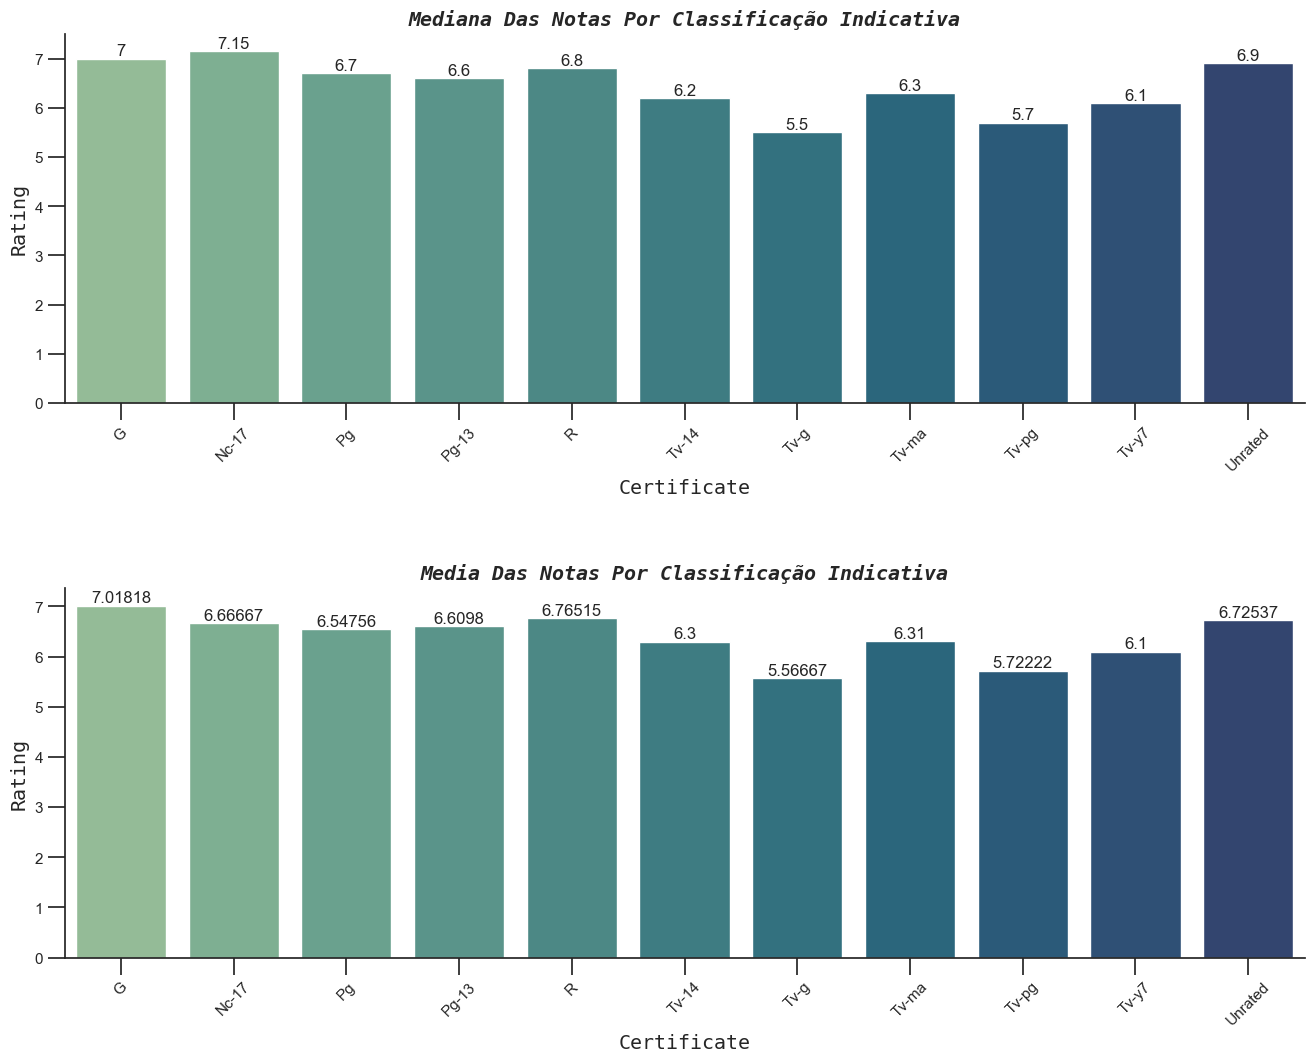

In [133]:
fig, (ax1, ax2) = plt.subplots((2), figsize=(16, 12))
create_bar(df, ax1, 'certificate', 'rating', 'median', 'Mediana das notas por classificação indicativa')
create_bar(df, ax2, 'certificate', 'rating', 'mean', 'Media das notas por classificação indicativa')
plt.subplots_adjust(hspace=.5)
plt.show()

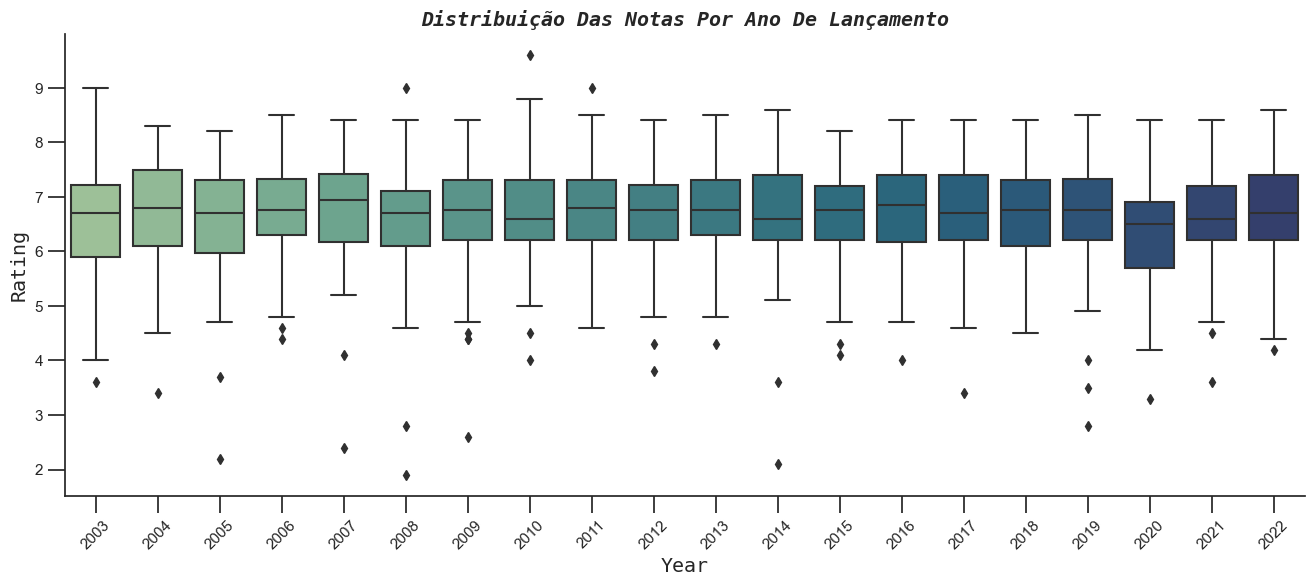

In [134]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df, ax, 'year', 'rating', 'Distribuição das notas por ano de lançamento')
plt.show()

 80%|████████  | 923/1151 [10:31<02:36,  1.46it/s]  


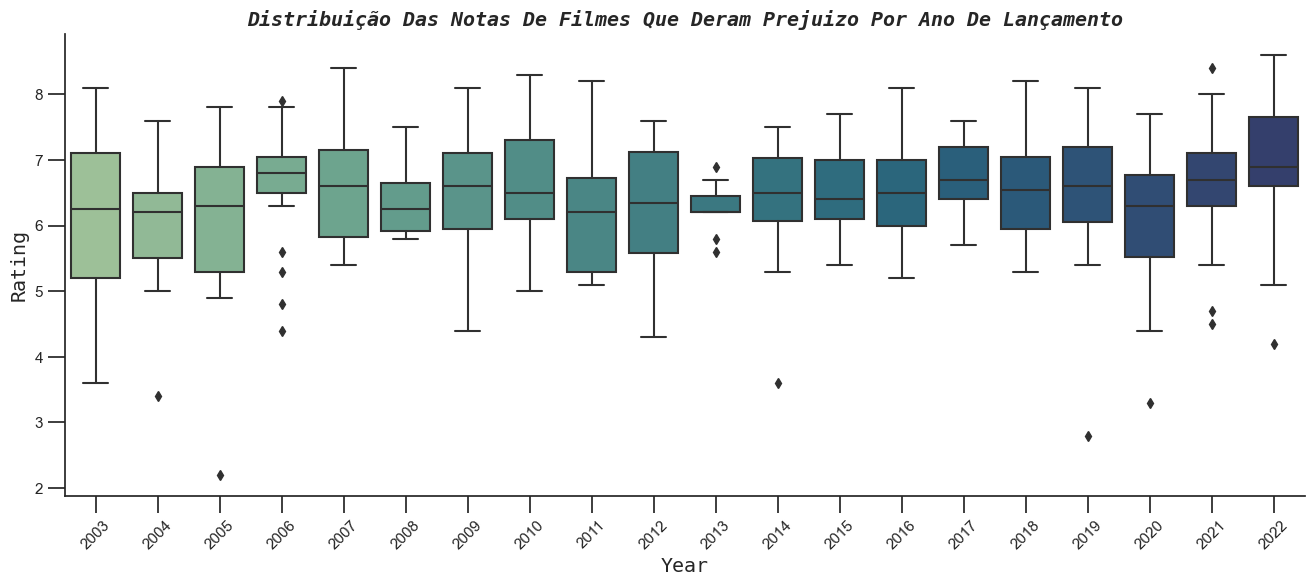

In [135]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df.query('profit_classification == "failure"'), ax, 'year', 'rating', 'Distribuição das notas de filmes que deram prejuizo por ano de lançamento')
plt.show()

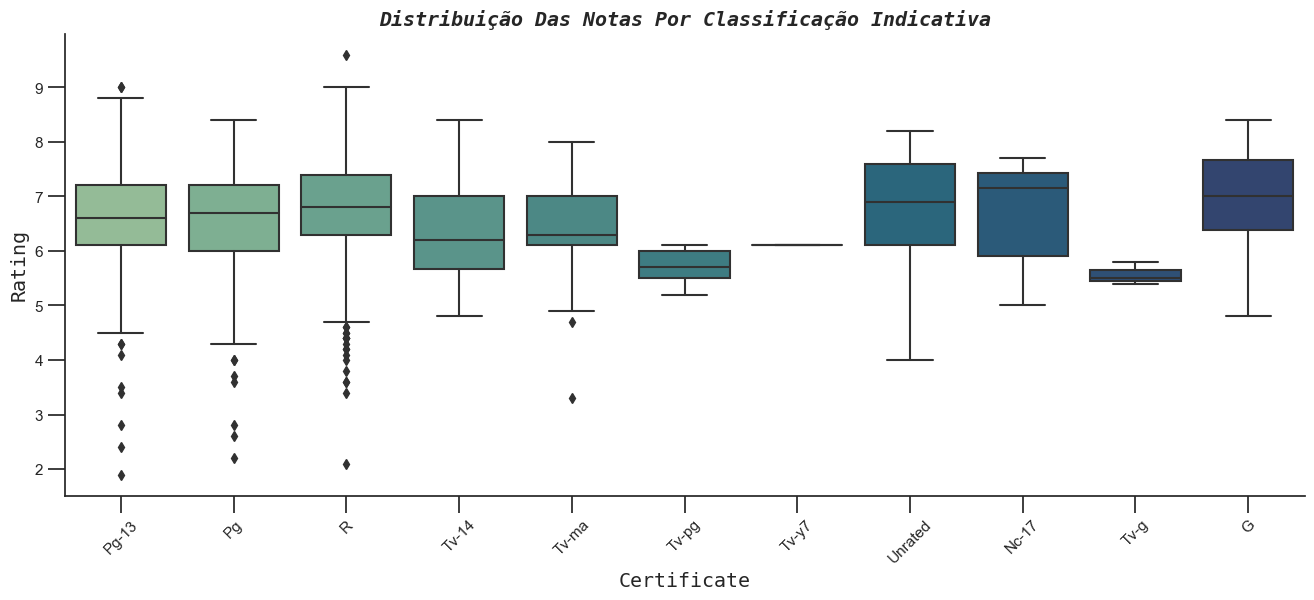

In [136]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df, ax, 'certificate', 'rating', 'Distribuição das notas por classificação indicativa')
plt.show()

In [137]:
df.time_classification.unique()

array(['eternity', 'medium', 'long', 'short'], dtype=object)

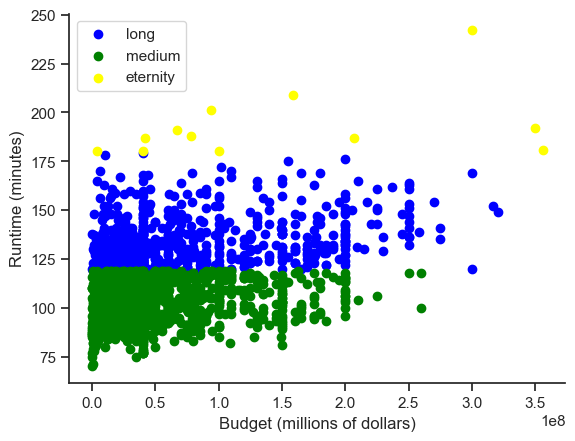

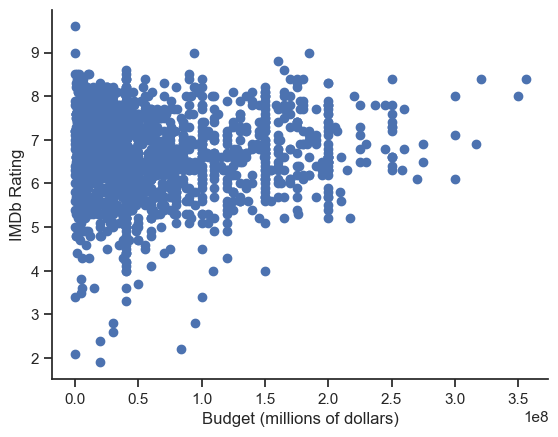

In [138]:
colors = {'long': 'blue', 'medium': 'green', 'eternity': 'yellow'}
for time_classification, color in colors.items():
    plt.scatter(df[df['time_classification'] == time_classification]['budget'], df[df['time_classification'] == time_classification]['runtime'], c=color, label=time_classification)

plt.xlabel('Budget (millions of dollars)')
plt.ylabel('Runtime (minutes)')
plt.legend()
plt.show()

plt.scatter(df['budget'], df['rating'])
plt.xlabel('Budget (millions of dollars)')
plt.ylabel('IMDb Rating')
plt.show()

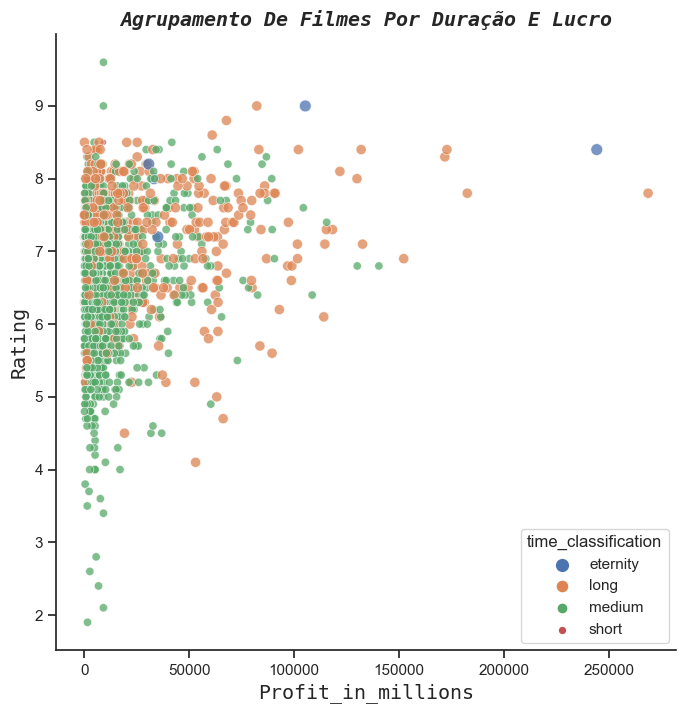

In [139]:
fig, ax = plt.subplots(figsize=(8, 8))

df_to_scatter = df.query('profit_classification == "gain"').copy()
df_to_scatter['profit_in_millions'] = df_to_scatter.profit/10_000
create_scatter(df_to_scatter, ax, 'profit_in_millions', 'rating', 'time_classification', 'Agrupamento de filmes por duração e lucro')
del df_to_scatter

plt.show()

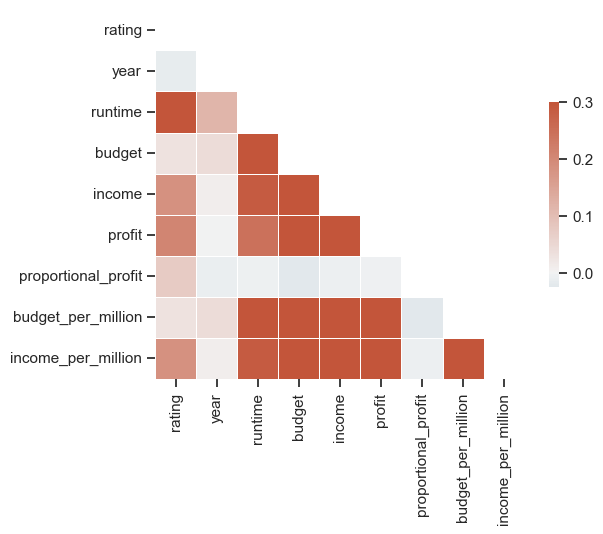

In [140]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [141]:
corr

,rating,year,runtime,budget,income,profit,proportional_profit,budget_per_million,income_per_million
rating,1.000000,-0.015021,0.378195,0.030098,0.183770,0.207080,0.073403,0.030098,0.183770
year,-0.015021,1.000000,0.117568,0.041467,0.009415,0.000662,-0.009237,0.041467,0.009415
runtime,0.378195,0.117568,1.000000,0.360932,0.286372,0.244452,-0.005881,0.360932,0.286372
budget,0.030098,0.041467,0.360932,1.000000,0.731249,0.604683,-0.024159,1.000000,0.731249
income,0.183770,0.009415,0.286372,0.731249,1.000000,0.985452,-0.008119,0.731249,1.000000
profit,0.207080,0.000662,0.244452,0.604683,0.985452,1.000000,-0.003461,0.604683,0.985452
proportional_profit,0.073403,-0.009237,-0.005881,-0.024159,-0.008119,-0.003461,1.000000,-0.024159,-0.008119
budget_per_million,0.030098,0.041467,0.360932,1.000000,0.731249,0.604683,-0.024159,1.000000,0.731249
income_per_million,0.183770,0.009415,0.286372,0.731249,1.000000,0.985452,-0.008119,0.731249,1.000000


## Georef

In [142]:
gdf = gpd.read_file('../datasets/georef/world_countries.shp')[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [143]:
rating = analise_2colunas(df['country_of_origin'], df['rating'], ['country', 'rating'])
rating = rating.groupby(['country'], as_index = False).agg(mean = ('rating', 'mean'))
rating.loc[rating['country'] == 'United States',  'country'] = 'United States of America'
rating.head()

,country,mean
0,Argentina,7.633333
1,Australia,6.625000
2,Austria,6.600000
3,Bahamas,8.000000
4,Belgium,6.792593


In [144]:
merged = gdf.merge(rating, on = 'country')
merged_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)
merged.head()

,country,country_code,geometry,mean
0,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",6.508756
1,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",6.637052
2,Indonesia,IDN,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",6.850000
3,Argentina,ARG,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",7.633333
4,Chile,CHL,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...",5.750000


In [145]:
geosource = GeoJSONDataSource(geojson = json_data)
palette = brewer['YlGnBu'][8]
palette = palette[::-1]
color_mapper = LinearColorMapper(palette = palette)

color_bar = ColorBar(color_mapper = color_mapper,
                     label_standoff = 8,
                     width = 500,
                     height = 20,
                     border_line_color = None,
                     location = (0,0),
                     orientation = 'horizontal')

mapa = figure(title = 'Média das avaliações de acordo com os países de origem',
           height = 450,
           width = 850,
           toolbar_location = None)

mapa.xgrid.grid_line_color = None
mapa.ygrid.grid_line_color = None

mapa.patches('xs',
          'ys',
          source = geosource,
          fill_color = {'field' :'mean','transform' : color_mapper},
          line_color = 'black',
          line_width = 0.25,
          fill_alpha = 1)

mapa.add_layout(color_bar, 'below')
output_notebook()
show(mapa)

Loading BokehJS ...